#  Multiple classes classification  with Logistic Regression and Neural Networks of an Industrial Machine

We have an **Machine** such as gas Turbine with several a series of recordings of the status of the machine. The acquisition  process is based on **60 different sensors** which record different aspects of the 
process.
An expert manually associates the state of the process to some selected recording.
This process has **4 different states**. The state 1 represents the **normal behaviour** of the process, while the other states reflects **anomalies** or **uncertainties**.
The samples are provided in a random order. Acquisition i has no direct correlation  with acquisition i+1.


<img src="img/turbine.gif" width="640">



### Task
Have a software that automatically understands **which is the current state 
of the machine**, based on the sensor values.

### Solution

Classification techniques are an essential part of machine learning and data mining applications. Approximately 70% of problems in Data Science are classification problems. There are lots of classification problems that are available, but the logistics regression is common and is a useful regression method for solving the binary classification problem.  However for our problem is not binnary, we have Multinomial classification, which handles the issues where multiple classes are present in the target variable.  In the multiclass case, the training algorithm  we will use is  the one-vs-rest (OvR) scheme and Neural Network technique to develop the software that allow us know the current state of the machine.






### Libraries

We need load the following libraries:

In [1]:
# Numpy
import numpy as np
from numpy import concatenate
# Pandas
import pandas
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# Matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
import itertools
# imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
# Seaborn and scipy (optional)
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import scipy
# Import statsmodels
import statsmodels.api as sm
import math

## Read data and labels from disk

In [2]:
states = np.load('states.npy')
df_states = pd.DataFrame(states)
sensors = np.load('sensors.npy')
df_sensor = pd.DataFrame(sensors)

We define one helper function to identify the null values

In [3]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [4]:
missing_values_table(df_states)

Your selected dataframe has 1 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
0,48330,90.0


In [5]:
#df_states.info()
df_states.isna().apply(pd.value_counts)

,0
True,48330
False,5370


We have 5370 rows that does not contain null values

In [6]:
missing_values_table(df_sensor)

Your selected dataframe has 60 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
35,13425,25.0
4,8055,15.0
9,537,1.0
18,537,1.0
33,537,1.0


In [7]:
#df_sensor.info()
df_sensor.isna().apply(pd.value_counts)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
False,53700.0,53700.0,53700.0,53700.0,45645,53700.0,53700.0,53700.0,53700.0,53163,...,53700.0,53700.0,53700.0,53700.0,53700.0,53700.0,53700.0,53700.0,53700.0,53700.0
True,NaN,NaN,NaN,NaN,8055,NaN,NaN,NaN,NaN,537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have found that there several columns that contains null values

## Data Wrangling

Due to we are interested to develop a **Mahine Learning Model** that it is abble to **Classify** the records of physical process we will take the classes that are different to null.


In [8]:
data_class=df_states.dropna(how='all')
print("There are ",len(data_class),"non null values that we can use")

There are  5370 non null values that we can use


We requiere to merge the dataframes of the  target with the sensors

In [9]:
# Merge two Dataframes on index of both the dataframes
mergedDf = data_class.merge(df_sensor, left_index=True, right_index=True)

In [10]:
print("There are ",len(mergedDf)," rows that contains the new dataframe")

There are  5370  rows that contains the new dataframe


We dont requiere the the original index for now, so we can reset them.

In [11]:
dfa=mergedDf.reset_index()

In addition le us rename the indexes in a better way

In [12]:
dfa.rename({'0_x': 'state', '0_y': 0}, axis=1, inplace=True)
del dfa['index']

In [13]:
dfa.head()

,state,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,1.0,11.496086,14.746733,26.721223,7.149618,22.570184,33.598819,29.250498,21.635644,19.684738,...,27.267261,19.154742,23.045132,31.047810,14.185418,23.967859,10.845980,16.355950,5.988377,25.352277
1,3.0,24.183004,15.157909,22.855529,31.329164,23.332737,22.974393,26.131904,18.743867,21.764996,...,21.011345,20.728923,21.895577,12.074077,23.950366,21.554332,34.618091,13.663964,27.307555,24.386600
2,1.0,25.502317,26.726849,20.783000,21.141776,21.588793,8.805463,22.792709,21.908904,15.520527,...,29.950599,21.795266,22.877302,28.792453,15.329257,27.557869,16.296140,22.222228,25.217641,29.894023
3,1.0,22.587548,21.866841,21.512478,14.517045,22.686410,28.095231,17.994564,26.171234,17.105065,...,25.013758,34.118962,19.585588,17.244331,18.622802,20.318998,27.111627,16.771745,22.088795,30.663813
4,1.0,29.875968,27.445935,23.742411,7.025355,25.913780,31.450550,19.440911,23.264211,18.895569,...,25.668524,30.490253,18.246760,26.713753,19.385017,23.079047,20.395495,20.932104,26.991767,24.092804


In [14]:
print("There are ",len(dfa)," rows in the working dataframe")

There are  5370  rows in the working dataframe


# Remove nan values

In [15]:
# drop all rows with any NaN and NaT values
dfc = dfa.dropna()

### Distribution of Data

In [16]:
def plot_histogram(df,feature_ind):
    bins=5
    data=df.iloc[feature_ind]
    fig, ax = plt.subplots()
    data.hist(bins= bins,ax=ax,facecolor='blue', alpha=0.5)
    ax.set_title("Sensor:"+ str(df.columns[feature_ind]),color='red')
    fig.tight_layout()
    plt.show()

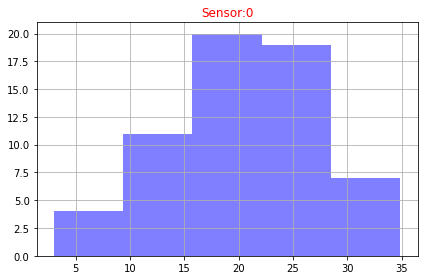

In [17]:
plot_histogram(dfc,1)

In [18]:
def plot_hisograms(df):
    features=df.columns
    rows = 12
    columns = 5
    fig = plt.figure(figsize=(10, 20))
    for i in range(1, columns*rows +1):
        ax=fig.add_subplot(rows, columns, i)
        data=df.iloc[i]
        bins = 10
        data.hist(bins= bins,ax=ax,facecolor='blue', alpha=0.5)
        ax.set_title("Sensor:"+str(features[i]),color='red')
    fig.tight_layout()  
   # plt.show()

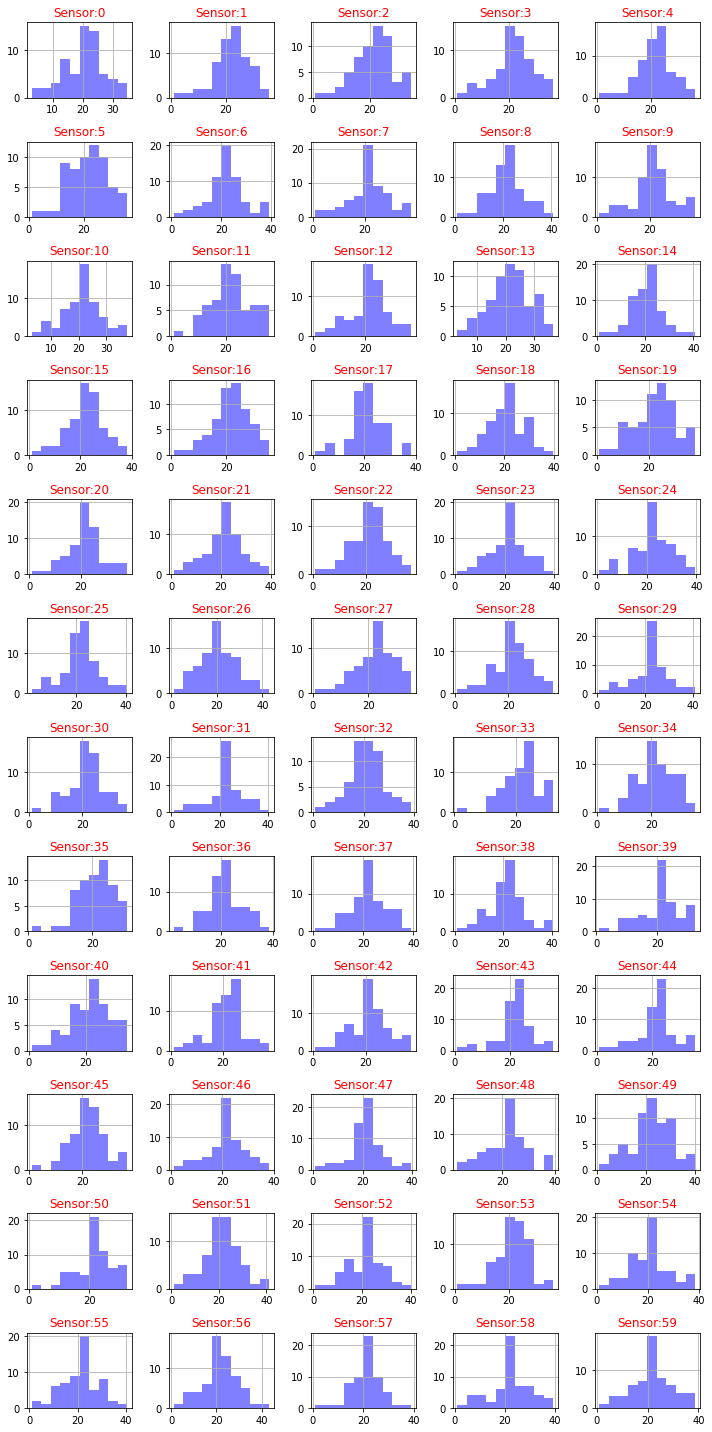

In [19]:
 plot_hisograms(dfc)

   We need to normalize the histogram, since the distribution of our plot is also normalized 

In [20]:
def plot_distribution(df,feature):
    data=df[feature]
    fig, ax = plt.subplots()
    num_bins = 20
    n, bins, patches = ax.hist(data, num_bins, density=1, alpha=0.5)
    mu, sigma = scipy.stats.norm.fit(data)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.ylabel('Probability')
    plt.title("Sensor:"+str(feature) + r'$:\    \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
    fig.tight_layout()
    plt.show()  

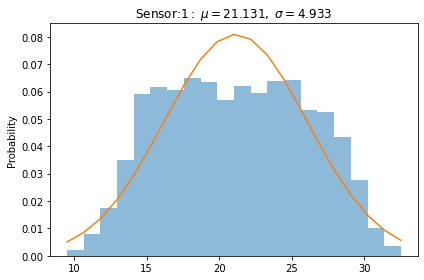

In [21]:
plot_distribution(dfc,dfc.columns[2])

In [22]:
def plot_distributions(dfa):
    df=dfa
    ### normal distribution of each feature of the data frame####
    
    size=df.shape[1]
    rows = int(math.ceil(size/4))
    n_rows = rows  
    n_cols=4
    size_grid=n_rows*n_cols
    size = len(df.columns)
    col=size
    i=0
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(2.5*n_cols, 2*n_rows))
    for column in df.iloc[:, 1:col]:
        axe=axes[i//n_cols,i%n_cols]
        sns.histplot(df[column],  stat="density",  kde=True,element="step", ax=axe)
        axe.axvline(df[column].mean(), c='k')  # Plot mean
        try:
            mu, sigma = scipy.stats.norm.fit(df[column]) 
            axe.set_title(str(column)+ r'$:\    \mu=%.2f,\ \sigma=%.2f$' %(mu, sigma),color='red')
        except RuntimeError :
                mu= df[column].mean()
                sigma= df[column].std()
                axe.set_title(str(column)+ r'$:\    \mu=%.2f,\ \sigma=%.2f$' %(mu, sigma),color='red')
                print("The column " + str(column)+" contains non-finite values.")      
        fig.tight_layout()
        i+=1

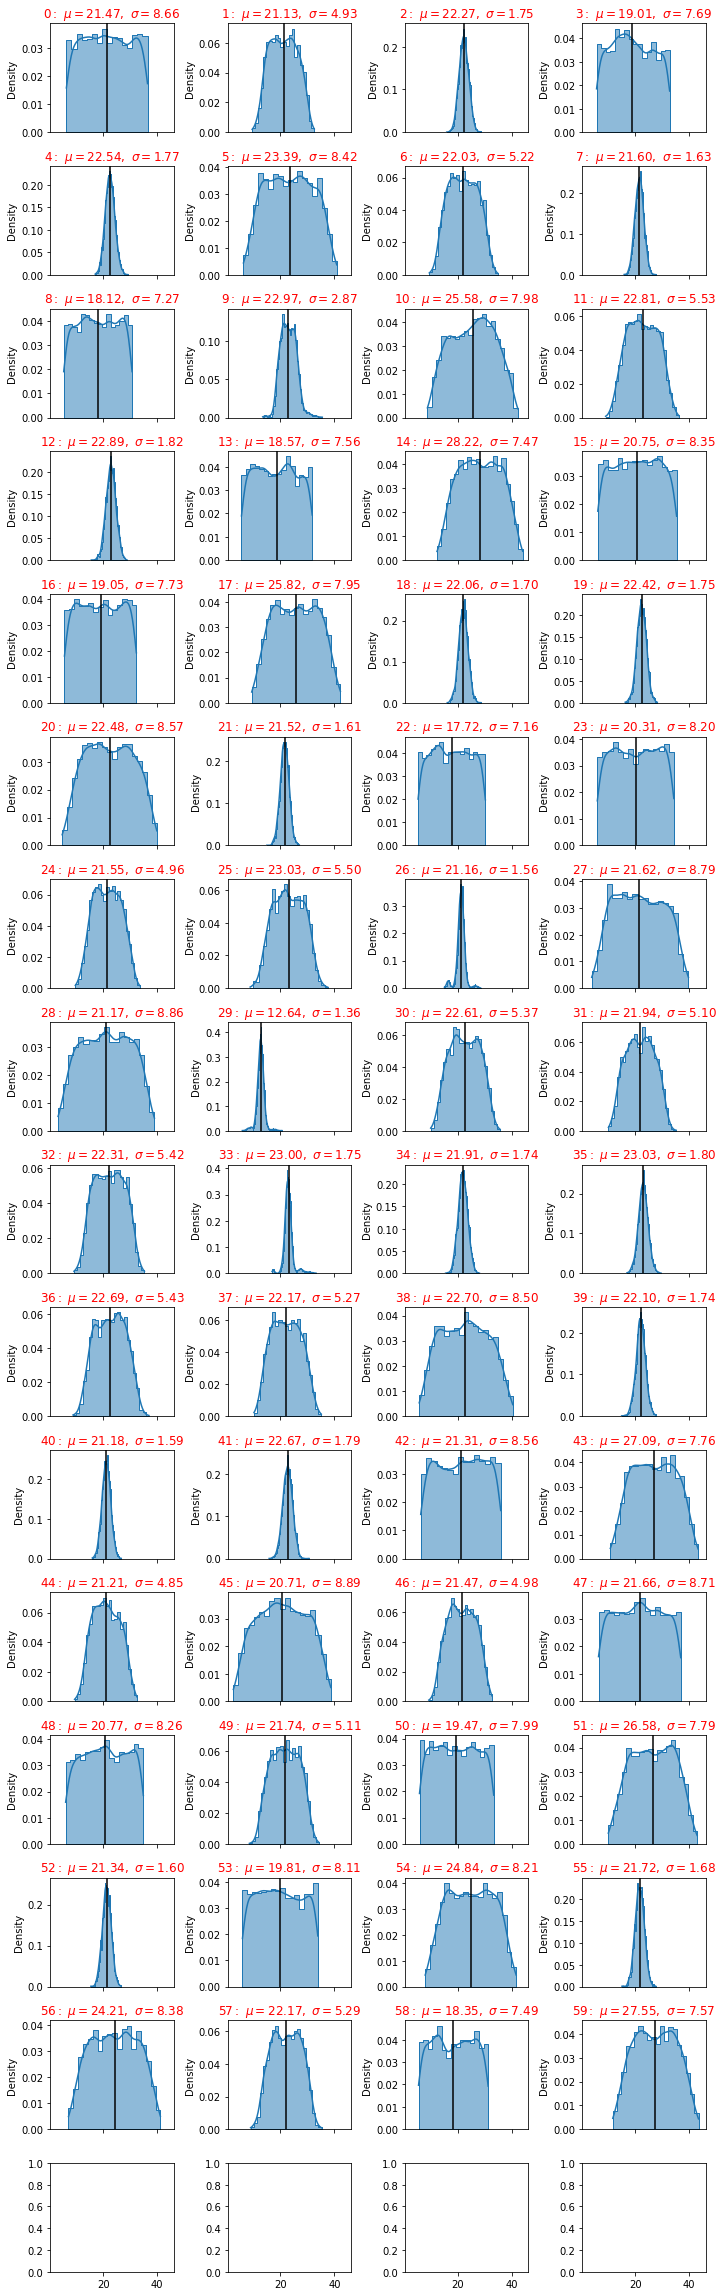

In [23]:
plot_distributions(dfc)

From the picture we have seen that some sensors have a big standard deviation, this fact can be used as a discriminant of the classification procedure.

Let us analize the correlations of all features, this can be used to reduce the dimensions of the problem.


## Correlations

In [24]:
from matplotlib.pyplot import figure
def correlations(dfa):
    corr = dfa.corr()
    fig = plt.figure(figsize=(6, 6), dpi=80)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(dfa.columns),1)
    plt.title('Correlations')
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(dfa.columns)
    ax.set_yticklabels(dfa.columns)
    plt.show()

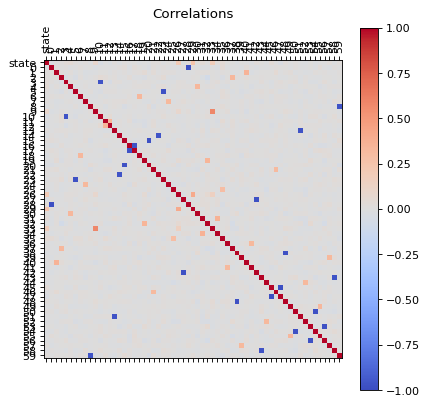

In [25]:
correlations(dfc)

We can see that there are some **features** that  are correlated, in principle we can reduce the dimensions by usig PCA, but before proceed with that let us first, perform an extra analysis of the data with a simple scree plot.

##  Diagnostic tool : A scree plot 

A scree plot displays how much variation each principal component captures from the data
A scree plot, on the other hand, is a diagnostic tool to check whether PCA works well on your data or not. Principal components are created in order of the amount of variation they cover: PC1 captures the most variation, PC2 — the second most, and so on. Each of them contributes some information of the data, and in a PCA, there are as many principal components as there are characteristics. Leaving out PCs and we lose information.

In the following line I will define a function that plots the  Scree plot

In [26]:
def principal(data):
    features=data.columns.tolist()
    data.index.names = ['record']
    # Separate data into Y and X 
    X=data[features]
    y = data.index
    # Subtract the mean
    X = X - X.mean()
    # Normalize
    Z = X / X.std()
    #Take the matrix Z, transpose it, and multiply the transposed matrix by Z. 
    #This is the covariance matrix of Z.
    Z = np.dot(Z.T, Z)
    eigenvalues, eigenvectors = np.linalg.eig(Z)
    D = np.diag(eigenvalues)
    P = eigenvectors
    Z_new = np.dot(Z, P)
    #1. Calculate the proportion of variance explained by each feature
    sum_eigenvalues = np.sum(eigenvalues)
    prop_var = [i/sum_eigenvalues for i in eigenvalues]
    #2. Calculate the cumulative variance
    cum_var = [np.sum(prop_var[:i+1]) for i in range(len(prop_var))]
    # Plot scree plot from PCA
    import matplotlib.pyplot as plt
    x_labels = ['PC{}'.format(i+1) for i in range(len(prop_var))]
    plt.plot(x_labels, prop_var, marker='o', markersize=6, color='skyblue', linewidth=2, label='Proportion of variance')
    plt.plot(x_labels, cum_var, marker='o', color='orange', linewidth=2, label="Cumulative variance")
    plt.legend()
    plt.title('Scree plot')
    plt.xlabel('Principal components')
    plt.ylabel('Proportion of variance')
    plt.show()
    
    
    dataset = pd.DataFrame({'PC': x_labels, 'Cumulative Variance': cum_var})
    dataset ['Delta_Variance'] = 0
    dataset['Delta_Variance'] = (abs(dataset['Cumulative Variance'] - dataset['Cumulative Variance'].shift(1)) )
    dataset.plot(x="PC", y="Delta_Variance")
    # selecting rows based on condition
    rslt_df = dataset[dataset['Delta_Variance']< 0.005]
    isempty = rslt_df.empty
    if  isempty != True:
        print(rslt_df)

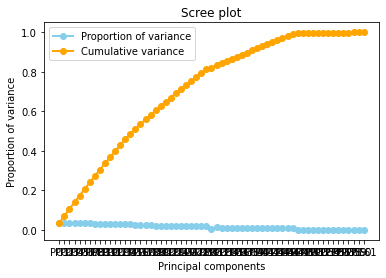

      PC  Cumulative Variance  Delta_Variance
47  PC48             0.993900        0.000662
48  PC49             0.994523        0.000623
49  PC50             0.995123        0.000601
50  PC51             0.995690        0.000567
51  PC52             0.996228        0.000538
52  PC53             0.996561        0.000333
53  PC54             0.997067        0.000507
54  PC55             0.997429        0.000362
55  PC56             0.997806        0.000377
56  PC57             0.998288        0.000482
57  PC58             0.998694        0.000405
58  PC59             0.999139        0.000445
59  PC60             0.999578        0.000439
60  PC61             1.000000        0.000422


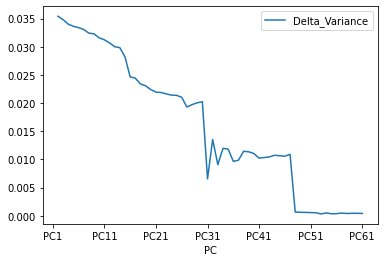

In [27]:
principal(dfc[dfc.columns])

A scree plot shows how much variation each principal component captures from the data. The y axis stands for the amount of variation . The plot on the left shows both amount of variation derived from each principal component and the cumulative variation that results from adding or considering another principal component for the model.

How many principal components to choose, comes down to a rule of thumb: the selected principal components should be able to describe at least 80–85% of the variance. 

In this case, we see that after   80% of variance there are some components that the Gradient of the variance is small, that means the does not contributues too much to the cumulative varaince.


The Cumulative at the end  have a **flat behavior**,the value of the slope of the tanget of the curve tends to zero. Than means that  in principle we can try to reduce the dimensions.

This is the conclusion of this small analysis. Let us identify what are the sensors that does not contributes too much to the problem.
There are two ways 
use take the principal components or use the random forest technique to identify the main features of the system.
Let us try use the random forest procedure.


In [28]:
def reduce(dfb):
    # Create correlation matrix
    corr_matrix = dfb.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.90
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    # Drop features 
    dfb_reduced=dfb.drop(to_drop, axis=1)
    return dfb_reduced

In [29]:
dfd = reduce(dfc)

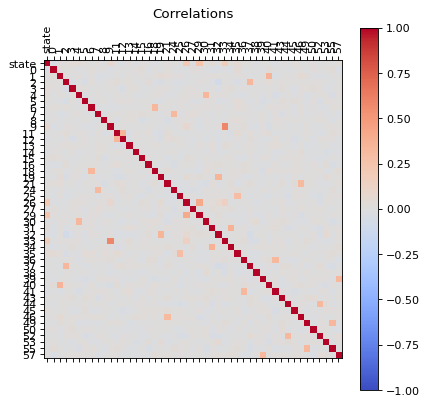

In [30]:
correlations(dfd)

Now our data has  less correlated points. 

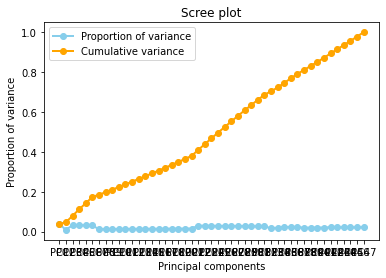

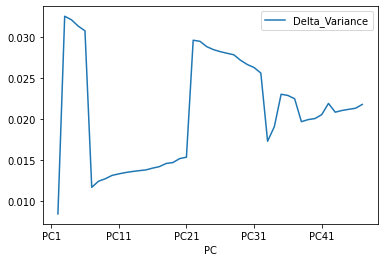

In [31]:
principal(dfd[dfd.columns])

And now the Cumulative varience does **not have flat behavior** , The tanget of the curve for the cumulative variance always is positive(see the first figure), and the increments of the delta variance tends to increase ( the second figure). 

Now we are in an appropiate setup to begin develop our Machine Learning Algorithm. Notice that we can even improve our dataset by analyzing outlayers for each sensor. But I would rather skip now this analysis. 

Now if we check the Histogram of the number of states we see the following:

array([[<AxesSubplot:title={'center':'state'}>]], dtype=object)

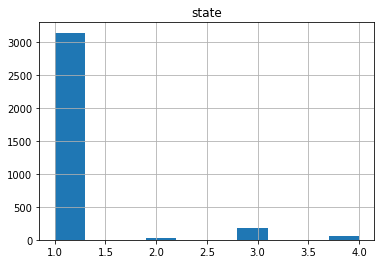

In [32]:
dfd.hist(column='state')

It seems that the most of the data corresponds to the first type of the state, we can create a neural network with the current status but is possible  that is not able to recognize well the other possible cases. Class Imbalance is a common problem in machine learning, especially in classification problems. Imbalance data can hamper our model accuracy big time.The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfishing. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information. So instead remove data, I will produce syntetic data to develop the neural network.


In [33]:
df1=dfd[dfd['state'] == 1.0]
df2=dfd[dfd['state'] == 2.0]
df3=dfd[dfd['state'] == 3.0]
df4=dfd[dfd['state'] == 4.0]

In [34]:
len(df1),len(df2),len(df3),len(df4)

(3141, 25, 186, 59)

## Removing outliers

In [35]:
import math
def plot_boxplot(df):
    size=df.shape[1]
    rows = int(math.ceil(size/5))
    columns = 5
    fig = plt.figure(figsize=(10, 20))
    for i in range(1, size):
        ax=fig.add_subplot(rows, columns, i)
        name=df.columns[i]
        sns.boxplot(x=df[name])
        ax.set_title('feature ='+str(name),color='red')
    fig.tight_layout()  
   # plt.show()

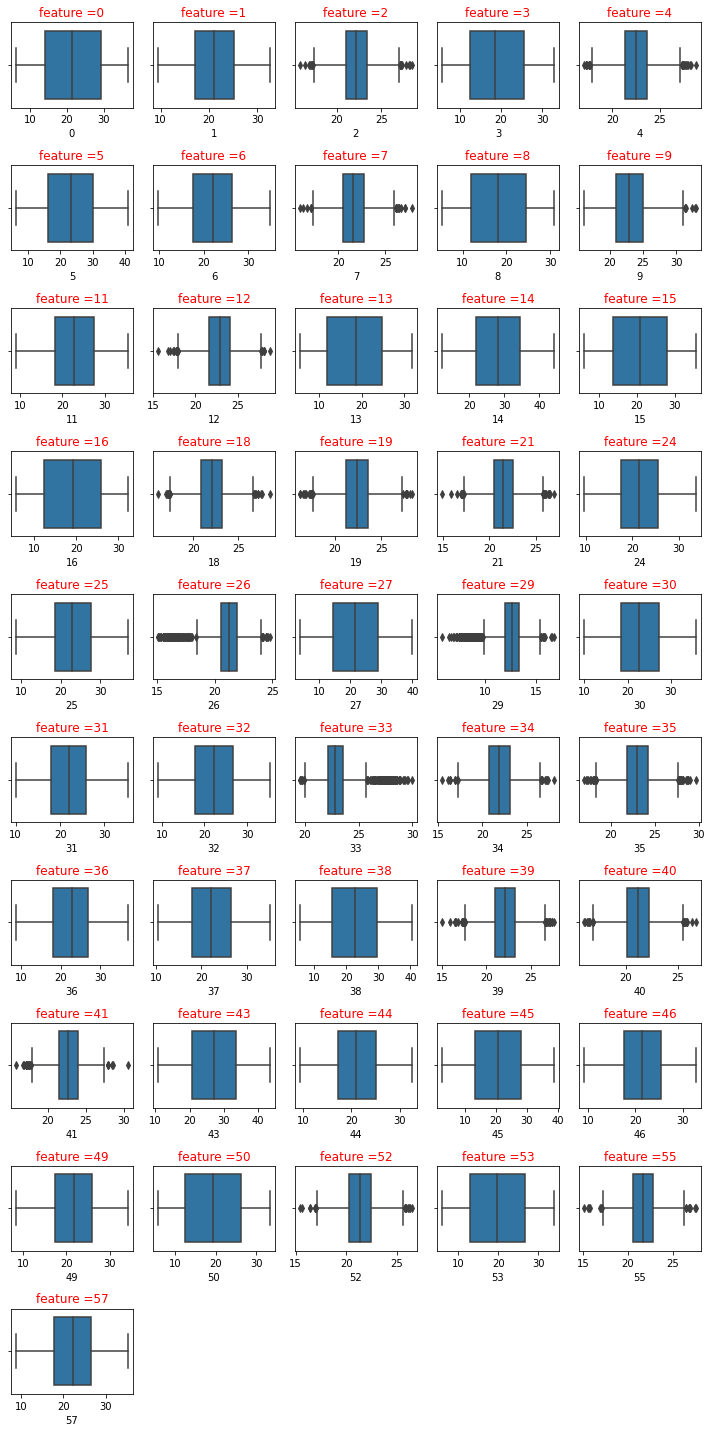

In [36]:
plot_boxplot(df1)

I will use interquartile range (IQR), to filter the outiers. In descriptive statistics, the interquartile range (IQR), also called the midspread, middle 50%, or H‑spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles.IQR = Q3 − Q1. In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data. It is a trimmed estimator, defined as the 25% trimmed range, and is a commonly used robust measure of scale. Source: Wikipedia

In [37]:
def remove_outliers_irq(data,parameterX):
    import seaborn as sns
    Q1 = data[parameterX].quantile(0.25)
    Q3 = data[parameterX].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[parameterX] >= Q1 - 1.5 * IQR) & (data[parameterX] <= Q3 + 1.5 *IQR)
    newdf=data.loc[filter]  
    return newdf

In [38]:
def remove_outliers(df):
    dfn=df
    features=dfn.columns
    size=len(dfn.columns)
    for i in range(1, size):
        dfn=remove_outliers_irq(dfn,dfn.columns[i])
    return dfn

We are going to remove the ouliers but for each type individually

In [39]:
df1b=remove_outliers(df1)
df2b=remove_outliers(df2)
df3b=remove_outliers(df3)
df4b=remove_outliers(df4)

In [40]:
frames = [df1b, df2b, df3b,df4b]
dfb = pd.concat(frames)

In [41]:
dfb.head()

,state,0,1,2,3,4,5,6,7,8,...,43,44,45,46,49,50,52,53,55,57
record,,,,,,,,,,,,,,,,,,,,,
0,1.0,11.496086,14.746733,26.721223,7.149618,22.570184,33.598819,29.250498,21.635644,19.684738,...,38.218918,18.160148,8.074117,27.424989,21.000445,27.267261,23.045132,31.047810,23.967859,16.355950
4,1.0,29.875968,27.445935,23.742411,7.025355,25.913780,31.450550,19.440911,23.264211,18.895569,...,17.665857,14.016229,6.573515,13.620976,24.618646,25.668524,18.246760,26.713753,23.079047,20.932104
6,1.0,13.774552,14.140539,23.454627,25.860453,23.219735,16.465780,25.760770,21.752649,29.150229,...,36.285757,19.817673,22.611933,24.509302,30.636301,18.504940,19.405997,31.972056,22.355431,22.563532
9,1.0,7.121402,24.641797,24.079103,18.602535,22.554538,26.621399,15.768406,21.721189,12.502055,...,30.639686,28.363854,15.653769,21.331473,27.968109,16.582878,20.727862,30.408854,22.537716,16.429178
10,1.0,17.193593,29.207429,21.541771,10.130416,25.356206,14.184588,22.026013,21.568314,6.620995,...,26.901092,27.996473,22.775784,26.790967,17.352350,20.400202,22.836806,15.168706,21.587638,24.274049


In [42]:
dfb.shape

(2894, 47)

array([[<AxesSubplot:title={'center':'state'}>]], dtype=object)

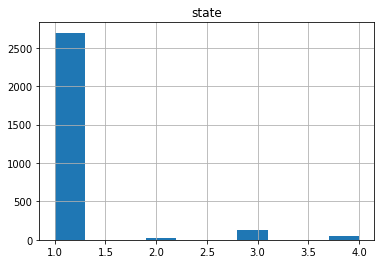

In [43]:
dfb.hist(column='state')

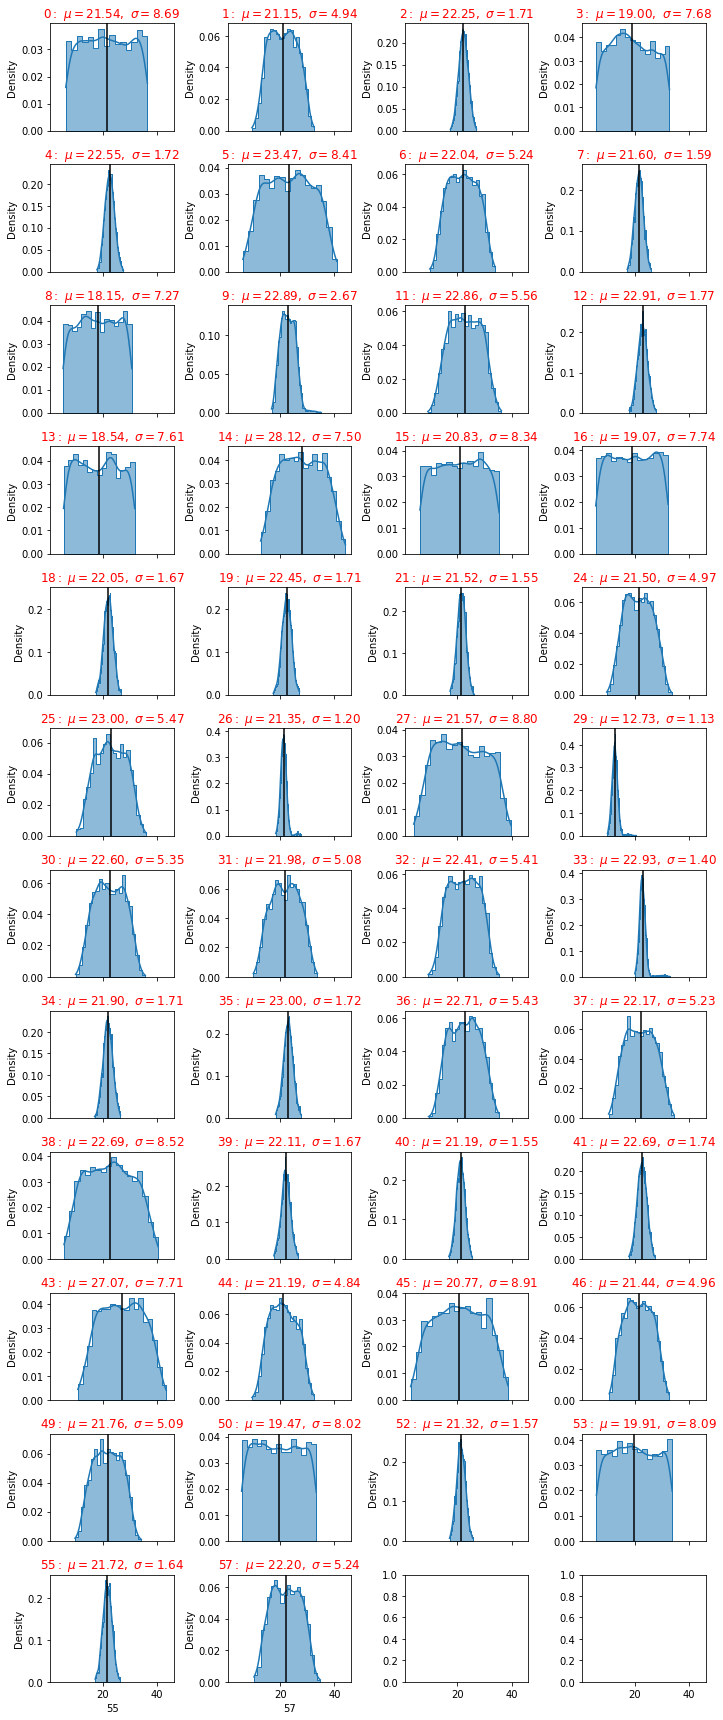

In [44]:
plot_distributions(dfb)

In [45]:
df1b=dfb[dfb['state'] == 1.0]
df2b=dfb[dfb['state'] == 2.0]
df3b=dfb[dfb['state'] == 3.0]
df4b=dfb[dfb['state'] == 4.0]

In [46]:
def dfdistributions(dfa):
    df1 = pd.DataFrame(columns=['feature', 'mu', 'sigma','sem(error)'])
    df=dfa
    col=len(df.columns)
    i=1
    for column in df.iloc[:, 1:col]:
                feature=int(df.columns[i])
                
                mu= df[column].mean()# get mean
                sigma= df[column].std()# get standard deviation
                
                #delta_min= mu-2sigma
                #delta_max= mu+2sigma
                
                
                err= df[column].sem() # get standard errors
                my_list =[feature,mu,sigma,err]
                df1.loc[i] =my_list 
                i+=1
    df1=df1.sort_values('sigma')
    df1['feature']=df1['feature'].astype(int)
    df1=df1.reset_index(drop=True)
    return df1

In [47]:
dfd=dfdistributions(dfb)
df1c=dfdistributions(df1b)
df2c=dfdistributions(df2b)
df3c=dfdistributions(df3b)
df4c=dfdistributions(df4b)

Standard Deviation tells how spread out the responses are -- are they concentrated around the mean, or scattered far & wide

A **low standard deviation** indicates that the values tend to be close to the mean (also called the expected value) of the set,

In [48]:
df1c.head()

,feature,mu,sigma,sem(error)
0,29,12.656626,0.973701,0.018756
1,33,22.784151,0.981201,0.018901
2,26,21.240850,0.981672,0.018910
3,21,21.523513,1.540165,0.029668
4,40,21.188451,1.546572,0.029791


where mu is the mean, sigma the standard deviation

while a **high standard deviation** indicates that the values are spread out over a wider range. The larger the standard deviation the more variance in the results.

In [49]:
df1c.tail()

,feature,mu,sigma,sem(error)
41,5,23.448057,8.394906,0.161710
42,38,22.736764,8.507013,0.163869
43,0,21.574531,8.718878,0.167950
44,27,21.617031,8.796663,0.169449
45,45,20.716196,8.897619,0.171394


SEM is calculated by taking the standard deviation and dividing it by the square root of the sample size. Standard error gives the accuracy of a sample mean by measuring the sample-to-sample variability of the sample means.


## Acceptable Standard Deviation (SD)

Statisticians have determined that values no greater than plus or minus 2 SD represent measurements that are more closely near the true value than those that fall in the area greater than ± 2SD.

Text(0, 0.5, 'standard deviation')

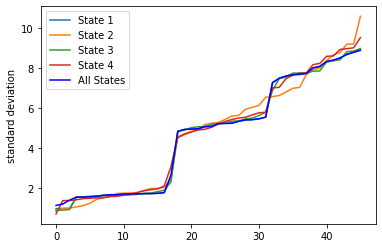

In [50]:
fig = plt.figure()
ax =df1c["sigma"].plot(label='df1')
df2c["sigma"].plot(ax=ax)
df3c["sigma"].plot(ax=ax)
df4c["sigma"].plot(ax=ax)
dfd["sigma"].plot(color='b',ax=ax)
ax.legend(["State 1", "State 2","State 3","State 4","All States"]);
plt.ylabel('standard deviation')


A high standard deviation shows that the data is widely spread (less reliable) and a low standard deviation shows that the data are clustered closely around the mean (more reliable)

So let us select all the sensors where  the standard deviation is less thant the mean of all standard deviations

In [51]:
df1c["sigma"].mean()

4.669190850786752

In [52]:
df1e=df1c.loc[df1c['sigma'] < df1c["sigma"].mean()]

In [53]:
df2e=df2c.loc[df2c['sigma'] < df2c["sigma"].mean()]

In [54]:
df3e=df3c.loc[df3c['sigma'] < df3c["sigma"].mean()]

In [55]:
df4e=df4c.loc[df4c['sigma'] < df4c["sigma"].mean()]

In [56]:
lista1=df1e['feature'].tolist()
lista2=df2e['feature'].tolist()
lista3=df3e['feature'].tolist()
lista4=df4e['feature'].tolist()

In [57]:
lista1.insert(0, "state")
lista2.insert(0, "state")
lista3.insert(0, "state")
lista4.insert(0, "state")

The lista 1,2,3 and 4 are the relevant sensors for each status of the machine

In [58]:
print(lista1)

['state', 29, 33, 26, 21, 40, 52, 7, 55, 18, 39, 19, 2, 34, 4, 35, 41, 12, 9]


In [59]:
print(lista2)

['state', 26, 29, 39, 33, 7, 40, 41, 34, 55, 21, 19, 35, 12, 4, 18, 2, 52, 9, 1]


In [60]:
print(lista3)

['state', 26, 33, 29, 7, 34, 2, 21, 39, 4, 40, 35, 18, 52, 12, 55, 41, 19, 9]


In [61]:
print(lista4)

['state', 26, 12, 52, 39, 19, 40, 35, 7, 55, 18, 41, 21, 2, 29, 34, 4, 33, 9, 49, 1]


we have seen that for each state there are different sensors that gives an important contibution


If we want to have a set of sensors that can give all the states, so we can use the intenserction 
of all those lists

In [62]:
# intersectionof two lists in most simple way
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [63]:
int1=intersection(lista1, lista2)
int2=intersection(int1, lista3)
int3=intersection(int2, lista4)

In [64]:
print("There are " +str(len(int3)-1)+ " sensors that we will use" )
int3

There are 18 sensors that we will use


['state', 29, 33, 26, 21, 40, 52, 7, 55, 18, 39, 19, 2, 34, 4, 35, 41, 12, 9]

In [65]:
df1f = df1b[int3]
df2f = df2b[int3]
df3f = df3b[int3]
df4f = df4b[int3]

In [66]:
df1f.head() 

,state,29,33,26,21,40,52,7,55,18,39,19,2,34,4,35,41,12,9
record,,,,,,,,,,,,,,,,,,,
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
4,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
6,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
9,1.0,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
10,1.0,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959


In [67]:
df2f.head() 

,state,29,33,26,21,40,52,7,55,18,39,19,2,34,4,35,41,12,9
record,,,,,,,,,,,,,,,,,,,
45,2.0,18.517175,29.457220,23.935484,22.570184,21.466337,21.445681,22.116501,20.834879,23.654019,22.682158,22.496208,24.168980,21.101974,21.592014,20.101001,21.599758,24.726746,31.220071
58,2.0,17.982780,28.064410,23.079517,18.978133,19.541744,19.072796,22.540752,22.510145,22.908271,20.856845,23.604754,22.636334,24.007725,24.382632,22.787191,20.280085,24.544608,31.338112
232,2.0,19.312899,30.916746,23.412281,20.147151,21.038135,23.241668,23.633133,21.123500,18.381836,22.288689,24.094215,24.897383,23.007532,22.175538,23.138984,22.014377,21.592349,30.826287
817,2.0,17.401330,28.537369,25.301944,20.293326,19.233027,19.796422,22.399979,22.776624,22.706890,23.112008,22.447534,24.481200,21.701331,23.985228,20.442196,19.834255,22.192292,28.701416
1144,2.0,17.282550,30.475085,23.767742,22.418678,20.119397,20.648349,23.694938,20.121213,18.371750,24.200866,24.744052,19.743823,21.214803,24.128766,19.927600,20.481967,22.780821,30.502319


In [68]:
frames = [df1f, df2f, df3f,df4f]
dfg = pd.concat(frames)

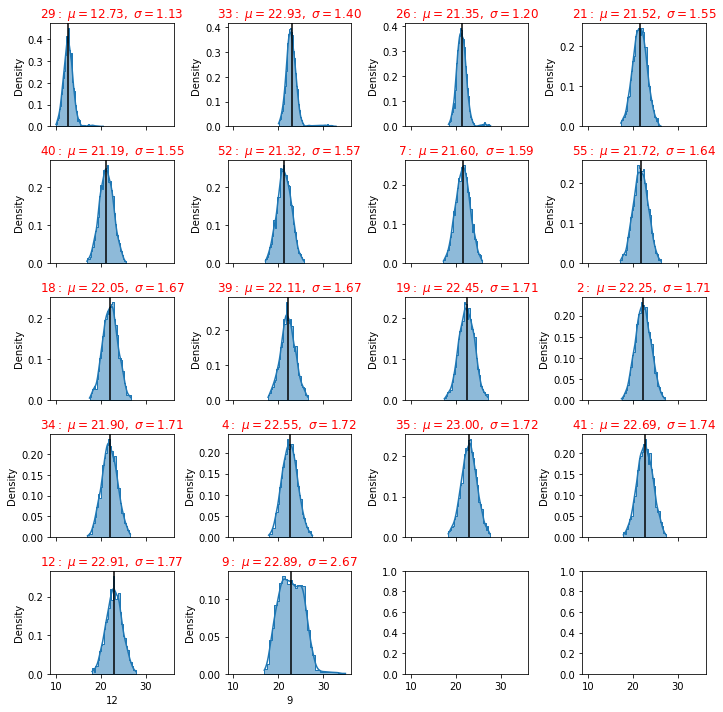

In [69]:
plot_distributions(dfg)

### Saving Setup

Some times if you need to return back to your current work, you can save the data already managed into a CSV file or parque or any convenient format.

In [70]:
dfg.to_csv('dfinal.csv', index=False)

In [71]:
df = pd.read_csv('dfinal.csv')

In [72]:
df.head()

,state,29,33,26,21,40,52,7,55,18,39,19,2,34,4,35,41,12,9
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
3,1.0,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
4,1.0,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959


array([[<AxesSubplot:title={'center':'state'}>]], dtype=object)

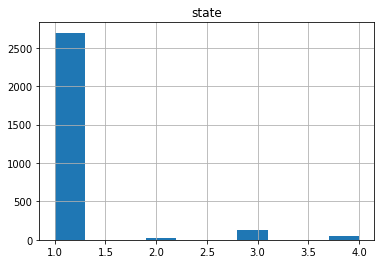

In [73]:
df.hist(column='state')

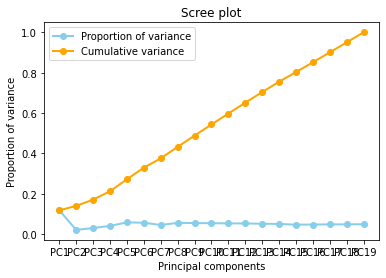

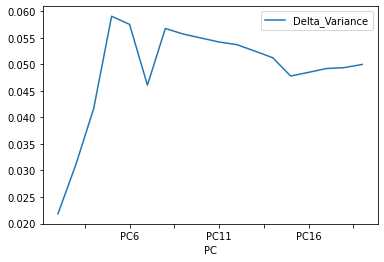

In [74]:
principal(df[df.columns])

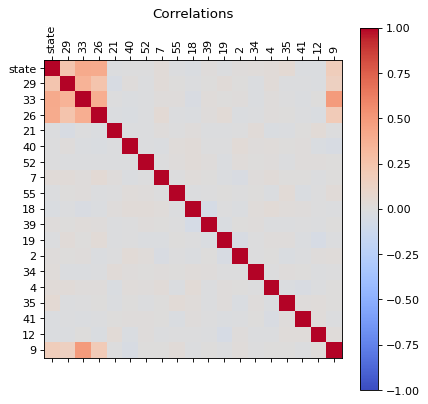

In [75]:
correlations(df)

In [76]:
df.head()

,state,29,33,26,21,40,52,7,55,18,39,19,2,34,4,35,41,12,9
record,,,,,,,,,,,,,,,,,,,
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
3,1.0,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
4,1.0,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959


In [77]:
data=df

In [78]:
data.state.describe()

count    2894.000000
mean        1.148238
std         0.565577
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: state, dtype: float64

C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


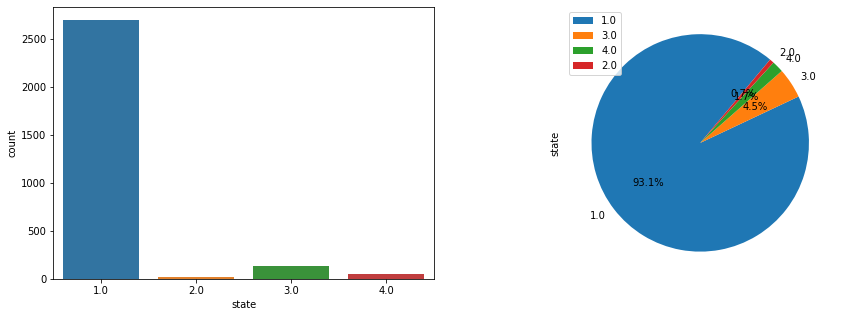

In [79]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
plt1 = sns.countplot(df['state'], ax = axs[0])
pie_state = pd.DataFrame(df['state'].value_counts())
pie_state.plot.pie( subplots=True,labels = pie_state.index.values, autopct='%1.1f%%', figsize = (15,5), startangle= 50, ax = axs[1])
# Unsquish the pie.
plt.gca().set_aspect('equal')
plt.show()

## Synthetic Minority Oversampling Technique (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [80]:
smote = SMOTE()

In [81]:
dataframe=df

In [82]:
dataset = dataframe.values
Y = dataset[:,0]  # We select what we want to predict
X = dataset[:,1:].astype(float) # We select the all the features

In [83]:
one = np.where(Y==1)
two = np.where(Y==2)
three = np.where(Y==3)
four = np.where(Y==4)

In [84]:
len(one[0]), len(two[0]), len(three[0]), len(four[0])

(2695, 19, 130, 50)

In [85]:
# fit target and predictor variable
x_smote , y_smote = smote.fit_resample(X, Y)

In [86]:
print('Original dataset shape:', Counter(Y))
print('Resampple dataset shape:', Counter(y_smote))

Original dataset shape: Counter({1.0: 2695, 3.0: 130, 4.0: 50, 2.0: 19})
Resampple dataset shape: Counter({1.0: 2695, 2.0: 2695, 3.0: 2695, 4.0: 2695})


In [87]:
# Create the dataframe
dfs=pd.DataFrame(x_smote)

In [88]:
dfs['state']=y_smote.tolist()

In [89]:
dfs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,state
0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335,1.0
1,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088,1.0
2,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143,1.0
3,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970,1.0
4,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959,1.0


I like work with the target in the first position 

In [90]:
# shift column 'states' to first position
first_column = dfs.pop('state')

In [91]:
# insert column using insert(position,column_name,first_column) function
dfs.insert(0, 'state', first_column)

In [92]:
dfs.head()

,state,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
3,1.0,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
4,1.0,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959


In [93]:
dfs.to_csv('df_smote.csv', index=False)


In [94]:
dfs = pd.read_csv('df_smote.csv')
dfs.head()

,state,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
3,1.0,12.927095,24.344075,22.447774,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
4,1.0,10.832813,22.338120,21.991345,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959


array([[<AxesSubplot:title={'center':'state'}>]], dtype=object)

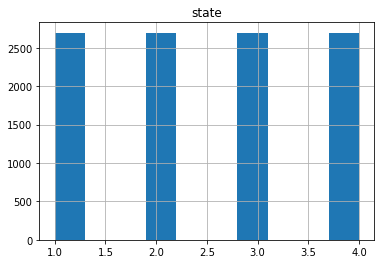

In [95]:
dfs.hist(column='state')

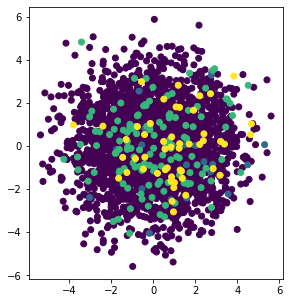

In [96]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
variables =df.columns[1:].tolist()
values= df.loc[:, variables].values
target_values=df.loc[:,['state']].values
X_pca = PCA().fit_transform(values)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_pca[:, 1], X_pca[:, 4], c=target_values)

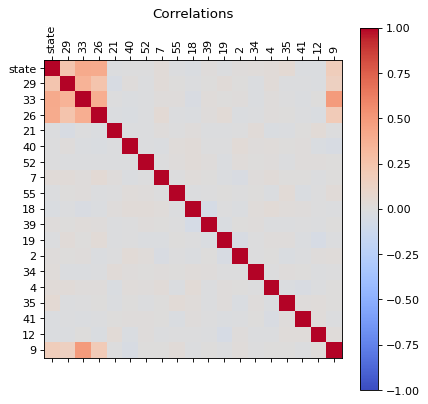

In [97]:
correlations(df)

In [98]:
#### Dropping highly correlated dummy variables

In [99]:
dfb=df

In [100]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)

    return(vif)

$VIF=\frac{1}{1-R^2}$

$R^2$ value is determined to find out how well an independent variable is described by the other independent variables. A high value of $R^2 $means that the variable is highly correlated with the other variables.

So, the closer the $R^2$ value to 1, the higher the value of VIF and the higher the multicollinearity with the particular independent variable.

VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “

or

VIF score of an independent variable represents how well the variable is explained by other independent variables.

In [101]:
df_X = dfb.iloc[:,1:-1]
vif=calc_vif(df_X)
vif

,variables,VIF
2,26,361.872351
1,33,342.020020
3,21,181.837057
4,40,177.659985
6,7,176.756179
5,52,175.356509
14,35,169.758559
8,18,167.589478
7,55,166.345145
9,39,165.637735


VIF starts at 1 and has no upper limit
VIF = 1, no correlation between the independent variable and the other variables
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

Dropping variables should be an iterative process starting with the variable having the largest VIF value because its trend is highly captured by other variables. If you do this, you will notice that VIF values for other variables would have reduced too, although to a varying extent.



<AxesSubplot:xlabel='variables', ylabel='VIF'>

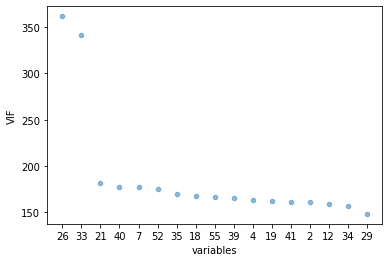

In [102]:
vif.plot.scatter(x="variables", y="VIF", alpha=0.5)

In [103]:
mean, std = vif.VIF.agg([np.mean, np.std])

In [104]:
to_drop=vif.loc[(vif['VIF'] >= mean)]

In [105]:
drop_list=to_drop['variables'].tolist()

In [106]:
dfb.shape

(2894, 19)

In [107]:
# Remove  columns name 
dfg=dfb.drop(drop_list, axis = 1)

In [108]:
dfg.shape

(2894, 17)

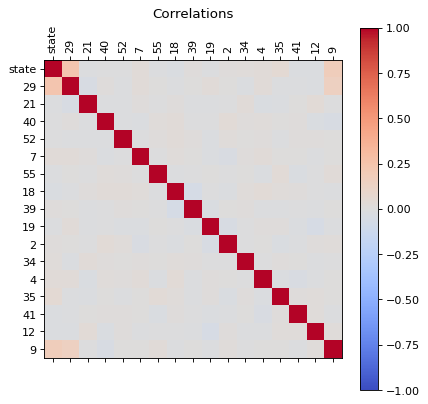

In [109]:
correlations(dfg)

In [110]:
dfg_reduced  = reduce(dfg)

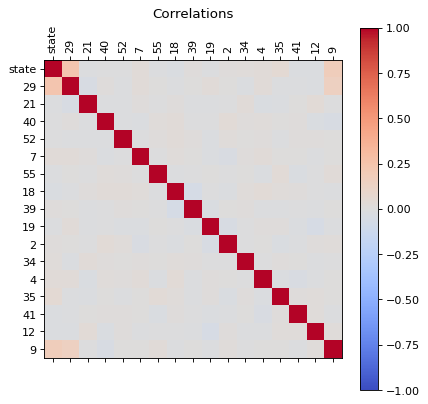

In [111]:
correlations(dfg_reduced )

In [112]:
dfg_reduced

,state,29,21,40,52,7,55,18,39,19,2,34,4,35,41,12,9
record,,,,,,,,,,,,,,,,,
0,1.0,11.974782,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143
3,1.0,12.927095,18.373254,21.367511,20.727862,21.721189,22.537716,23.523637,20.941238,20.922298,24.079103,20.039817,22.554538,22.852923,20.342647,25.666162,27.276970
4,1.0,10.832813,20.308396,21.579734,22.836806,21.568314,21.587638,19.515942,22.674051,19.717835,21.541771,23.155091,25.356206,22.639545,19.074855,21.252032,25.146959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,4.0,17.293419,21.745736,19.150968,19.911343,20.877967,19.278143,21.376266,23.307928,21.457416,21.153553,18.408535,21.300583,21.036249,22.022886,22.749105,32.620455
2890,4.0,13.215658,25.342674,21.373345,21.894849,23.131016,21.409530,21.925422,23.787103,20.999908,24.786548,19.312061,24.371714,23.990443,23.509149,23.816427,24.841819
2891,4.0,15.943436,20.408695,20.370232,23.273113,22.145746,20.241535,18.142175,22.840490,24.126766,22.987190,18.660558,24.780584,25.666098,23.190211,23.282463,26.711100


In [113]:
def plot_classes(df,feature1,feature2):
    fig, axs = plt.subplots(2,2, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    mylist = list( dict.fromkeys(df['state'].tolist()) )
    targets =mylist
    colors = ['r', 'g', 'b','y']
    axs = axs.ravel()
    for i in range(len(targets)):
        target=targets[i]
        indicesToKeep = df['state'] == target
        axs[i].scatter(df.loc[indicesToKeep, feature1]
             , df.loc[indicesToKeep, feature2]
             , c = colors[i]
             , s = 50)
        tit=str(target)
        axs[i].legend(tit)  

In [114]:
def plot_components(df,target_str,feature1,feature2):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Component 1') 
    ax.set_ylabel('Component 2') 
    ax.set_title(' ') 
    mylist = list( dict.fromkeys(df[target_str].tolist()) )
    targets =mylist
    colors = ['r', 'g', 'b','y']
    for target, color in zip(targets,colors):
             indicesToKeep = df[target_str] == target
             ax.scatter(df.loc[indicesToKeep, feature1]
             , df.loc[indicesToKeep, feature2]
             , c = color
             , s = 50)
            #ax.legend(targets)
           # ax.grid(

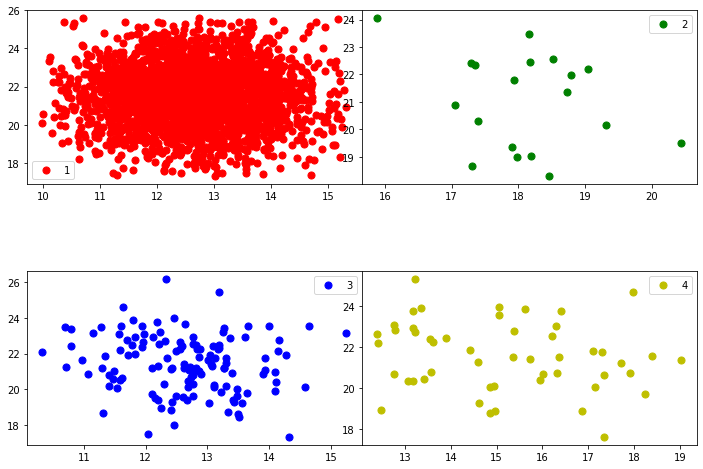

In [115]:
plot_classes(dfg_reduced,dfg_reduced.columns[1],dfg_reduced.columns[2])

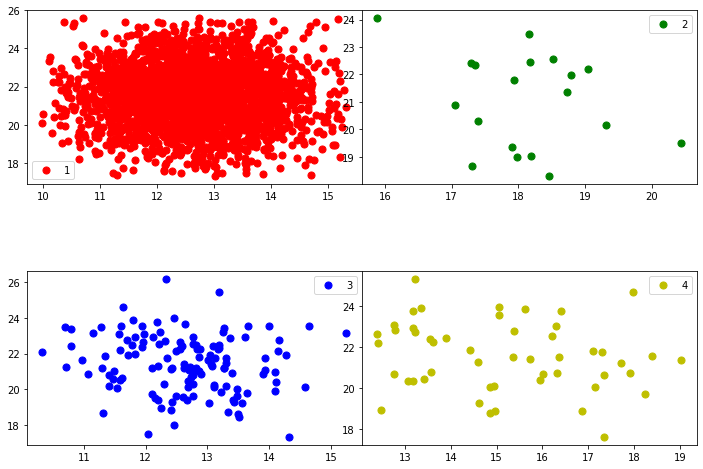

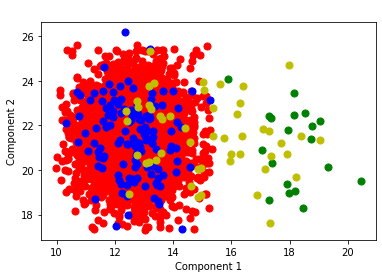

In [116]:
plot_classes(dfg_reduced,dfg_reduced.columns[1],dfg_reduced.columns[2])
plot_components(dfg_reduced,'state',dfg_reduced.columns[1],dfg_reduced.columns[2])

## Principal Component Analysis 

Standardization: All the variables should be on the same scale before applying PCA, otherwise, a feature with large values will dominate the result. 

In [117]:
from sklearn.preprocessing import StandardScaler

In [118]:
df=dfs

In [119]:
variables =df.columns[1:].tolist()

In [120]:
df.columns[:1].tolist()

['state']

In [121]:
x = df.loc[:, variables].values

In [122]:
y = df.loc[:,['state']].values

In [123]:
x = StandardScaler().fit_transform(x)

In [124]:
x = pd.DataFrame(x)

In [125]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.069128,1.167546,1.485746,-0.150805,-0.297908,-0.571361,1.321527,-1.513072,-0.320341,-2.658903,1.507271,-0.697791,1.847474,0.707705,0.386928,0.676697,0.816527,-0.067413
1,-0.567131,-2.241831,0.786830,0.170004,1.020575,0.636533,1.539490,1.315650,-0.336785,0.571612,1.418213,1.151461,1.518836,0.288880,0.287665,-0.443517,-0.023695,0.165677
2,-1.570187,0.138957,2.447613,0.016551,-0.597047,-0.272399,0.846207,0.470287,-1.325279,1.104747,0.704640,0.263953,0.440612,-0.309193,-0.373358,0.489454,-0.200686,0.109631
3,-0.410340,0.407984,1.448673,0.964565,1.224389,2.269986,0.323206,0.644732,0.747652,-1.594381,-0.138382,-0.042945,0.567315,-1.402657,0.393646,0.548537,0.797319,0.048997
4,-1.617539,-1.856374,-0.022272,-0.349744,-0.649542,-0.448818,0.713007,-0.317678,1.852405,-1.820153,-0.239495,-0.255499,-2.446328,-0.241097,0.599283,0.179846,0.980306,0.107808


In [126]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.19235919, 0.07746222, 0.07360103, 0.06728118, 0.06353866,
       0.06280017, 0.0585881 , 0.05644638, 0.05485307, 0.05067861,
       0.04667546, 0.04444898, 0.04116023, 0.04051884, 0.03512762,
       0.0210745 , 0.010363  , 0.00302277])

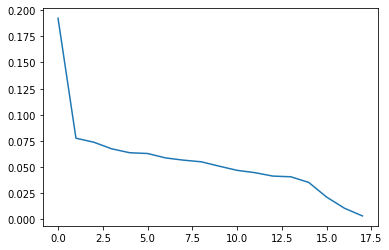

In [127]:
plt.plot(explained_variance.T )

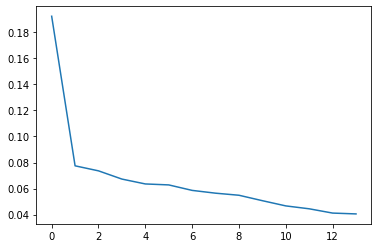

In [128]:
plt.plot(explained_variance[0:14].T )

In [129]:
x_pca['state']=y

In [130]:
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,state
0,-1.069128,1.167546,1.485746,-0.150805,-0.297908,-0.571361,1.321527,-1.513072,-0.320341,-2.658903,1.507271,-0.697791,1.847474,0.707705,0.386928,0.676697,0.816527,-0.067413,1.0
1,-0.567131,-2.241831,0.786830,0.170004,1.020575,0.636533,1.539490,1.315650,-0.336785,0.571612,1.418213,1.151461,1.518836,0.288880,0.287665,-0.443517,-0.023695,0.165677,1.0
2,-1.570187,0.138957,2.447613,0.016551,-0.597047,-0.272399,0.846207,0.470287,-1.325279,1.104747,0.704640,0.263953,0.440612,-0.309193,-0.373358,0.489454,-0.200686,0.109631,1.0
3,-0.410340,0.407984,1.448673,0.964565,1.224389,2.269986,0.323206,0.644732,0.747652,-1.594381,-0.138382,-0.042945,0.567315,-1.402657,0.393646,0.548537,0.797319,0.048997,1.0
4,-1.617539,-1.856374,-0.022272,-0.349744,-0.649542,-0.448818,0.713007,-0.317678,1.852405,-1.820153,-0.239495,-0.255499,-2.446328,-0.241097,0.599283,0.179846,0.980306,0.107808,1.0


In [131]:
x_pca.to_csv('dfpca.csv', index=False)

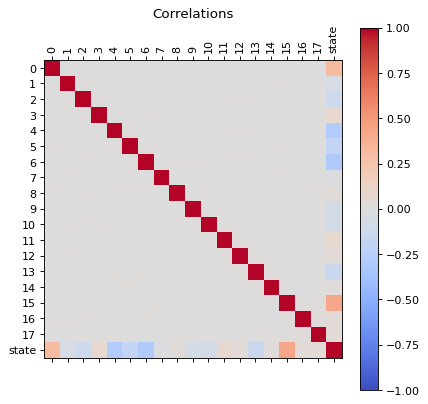

In [132]:
correlations(x_pca)

array([[<AxesSubplot:title={'center':'state'}>]], dtype=object)

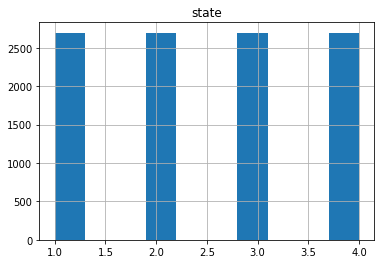

In [133]:
x_pca.hist(column='state')

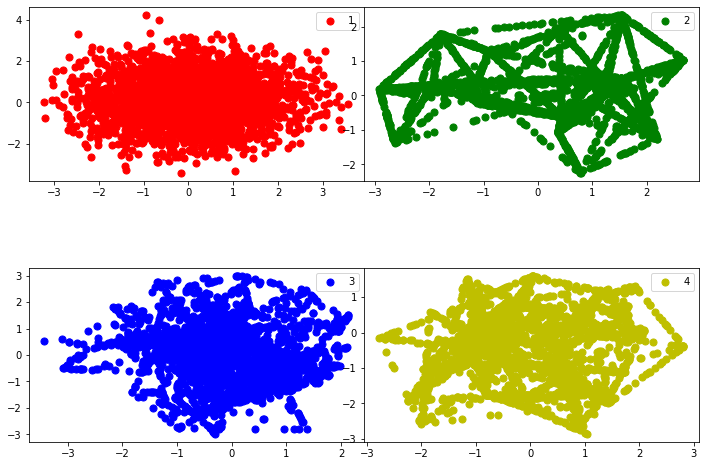

In [134]:
plot_classes(x_pca,1,5)

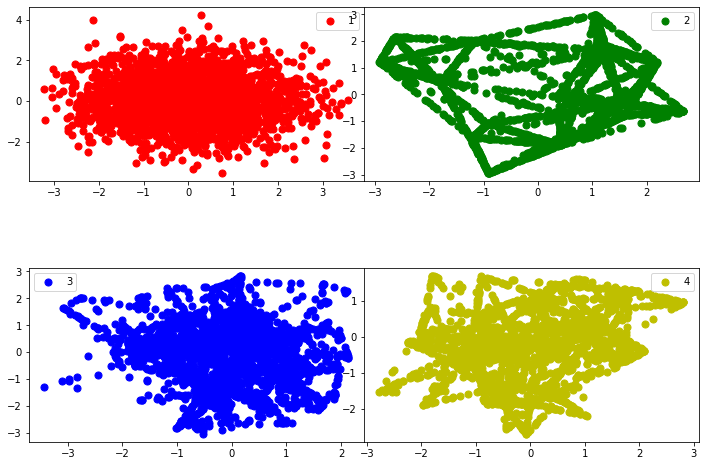

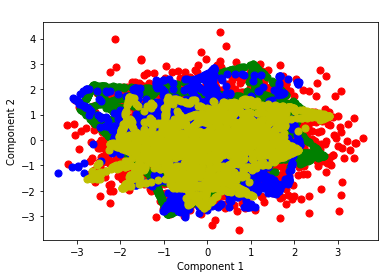

In [135]:
plot_classes(x_pca,1,2)
plot_components(x_pca,'state',1,2)

## Random Forest
Random Forest is one of the most widely used algorithms for feature selection. It comes packaged with in-built feature importance so you don’t need to program that separately. This helps us select a smaller subset of features.

We need to convert the data into numeric form by applying one hot encoding, as Random Forest (Scikit-Learn Implementation) takes only numeric inputs. Let’s also drop the target variables (state) as these are just unique numbers and hold no significant importance for us currently.

In [136]:
df1r=dfs[dfs['state'] == 1.0]
df2r=dfs[dfs['state'] == 2.0]
df3r=dfs[dfs['state'] == 3.0]
df4r=dfs[dfs['state'] == 4.0]

In [137]:
def feature_importance(dfc):
    from sklearn.ensemble import RandomForestRegressor
    dfd=dfc.drop(['state'], axis=1)
    model = RandomForestRegressor(random_state=1, max_depth=10)
    dfe=pd.get_dummies(dfd)
    model.fit(dfe,dfc)
    features = dfe.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-50:]  # top 50 features
    fig = plt.figure()
    fig = plt.figure(figsize=(10, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.ylabel('sensors')
    fig.tight_layout()
    plt.show()
    lista=indices.tolist()
    lista.reverse()
    list_fetures=lista
    list_importance=importances[indices].tolist()
    list_importance.reverse()
    # initialise data of lists.
    data = {'sensor':list_fetures,
            'Relative Importance':list_importance}
    # Create DataFrame of the feature analysis  
    df = pd.DataFrame(data)
    df['delta'] = abs(df['Relative Importance'] - df['Relative Importance'].shift(-1))
    return df

<Figure size 432x288 with 0 Axes>

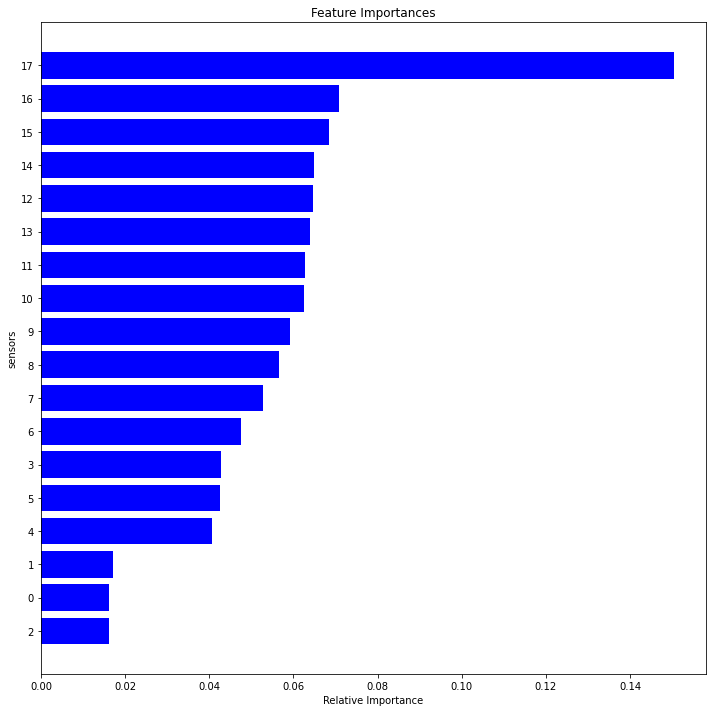

<Figure size 432x288 with 0 Axes>

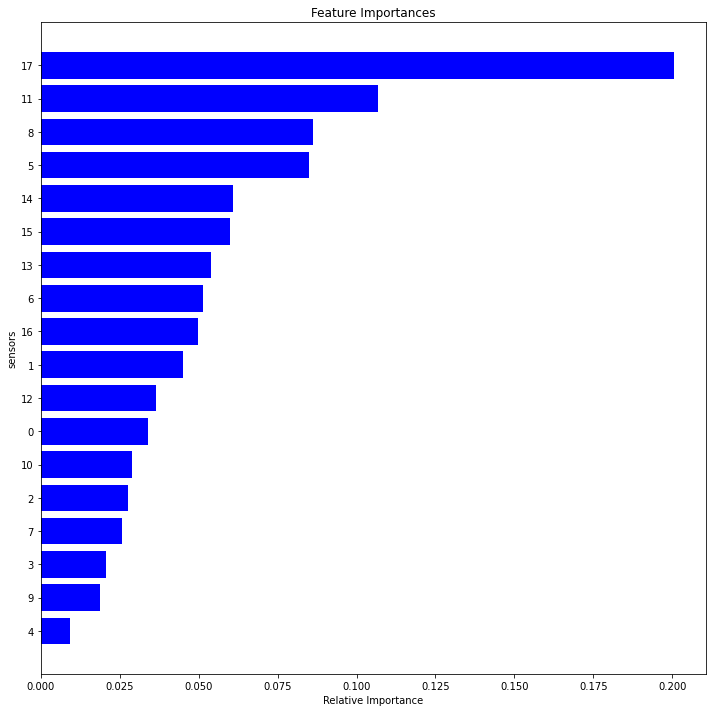

<Figure size 432x288 with 0 Axes>

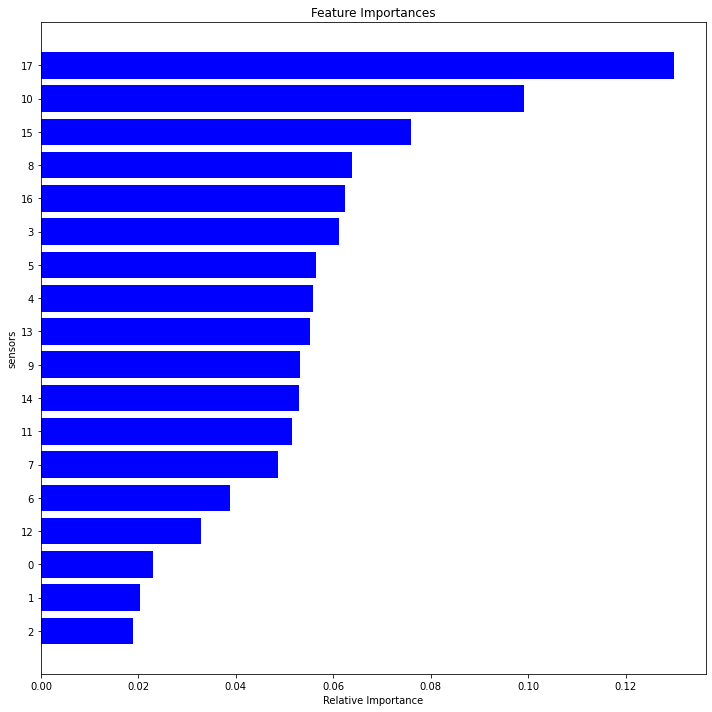

<Figure size 432x288 with 0 Axes>

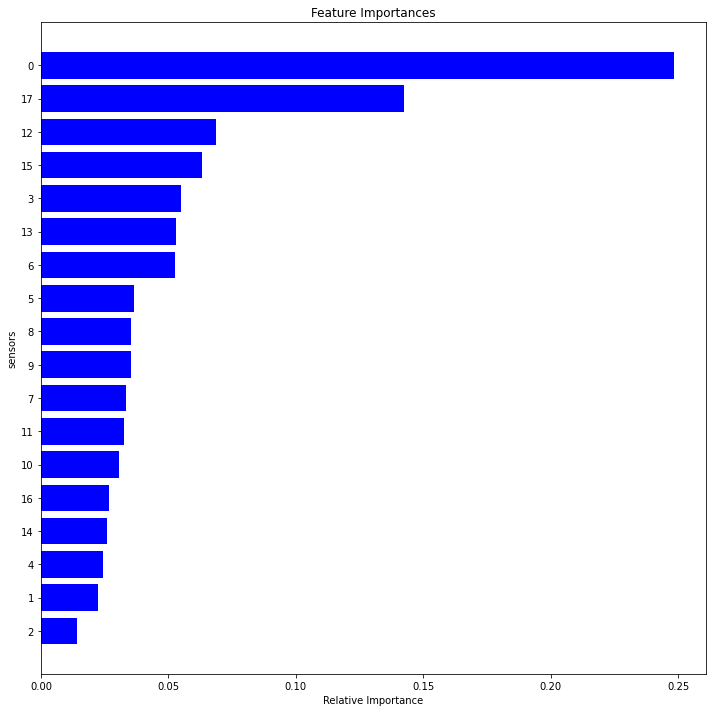

In [138]:
dim1=feature_importance(df1r)
dim2 =feature_importance(df2r)
dim3=feature_importance(df3r)
dim4=feature_importance(df4r)

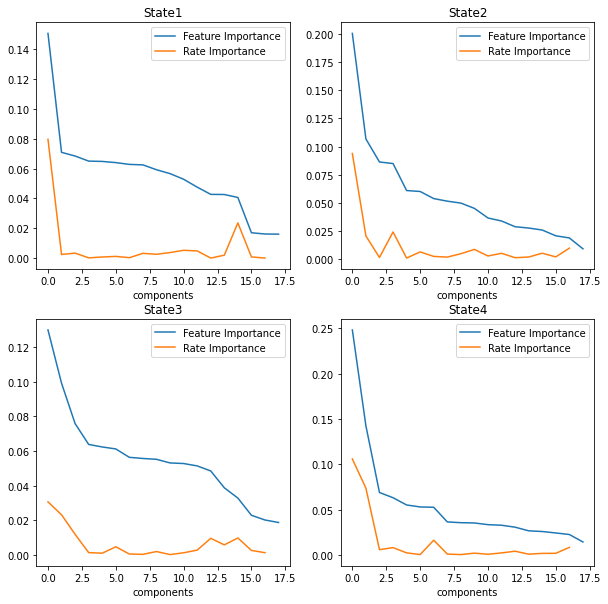

In [139]:
fig2, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
   # df[df.columns[i].plot(color=colors[i], ax=ax)
    name="dim"+str(i+1)
    locals()[name]["Relative Importance"].plot(ax=ax) 
    locals()[name]["delta"].plot(ax=ax)
    ax.legend(["Feature Importance", "Rate Importance"])
    ax.set_title("State"+ str(i+1))
    ax.set_xlabel('components')

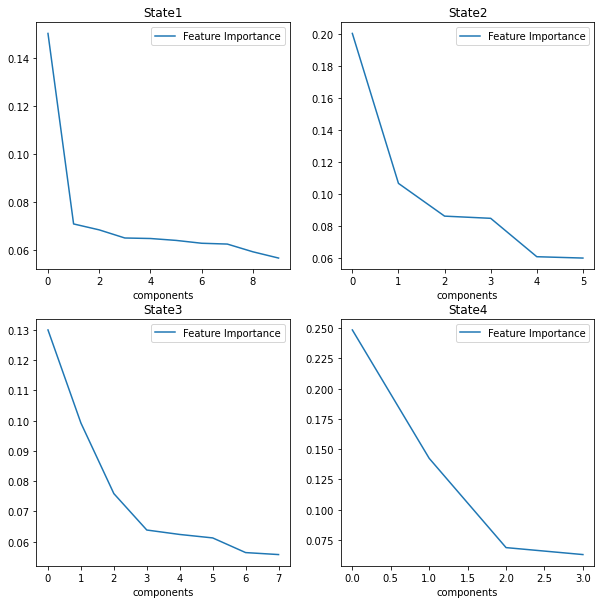

In [140]:
fig3, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
   # df[df.columns[i].plot(color=colors[i], ax=ax)
    name="dim"+str(i+1)
    std=locals()[name]['Relative Importance'].std()
    mean=locals()[name]['Relative Importance'].mean()
    rslt_df = locals()[name][locals()[name]['Relative Importance'] > mean]
    namef="features"+str(i+1)
    locals()[namef]=rslt_df
    rslt_df["Relative Importance"].plot(ax=ax) 
    ax.legend(["Feature Importance"])
    ax.set_title("State"+ str(i+1))
    ax.set_xlabel('components')


In [141]:
set1=features1.sensor.tolist()
set2=features2.sensor.tolist()
set3=features3.sensor.tolist()
set4=features4.sensor.tolist()

In [142]:
setall=set1+set2+set3+set4
relevant = list(dict.fromkeys(setall))
# mapping
relevant =list( map(str, relevant))
relevant.insert(0, "state")

In [143]:
dfr = dfs[relevant]

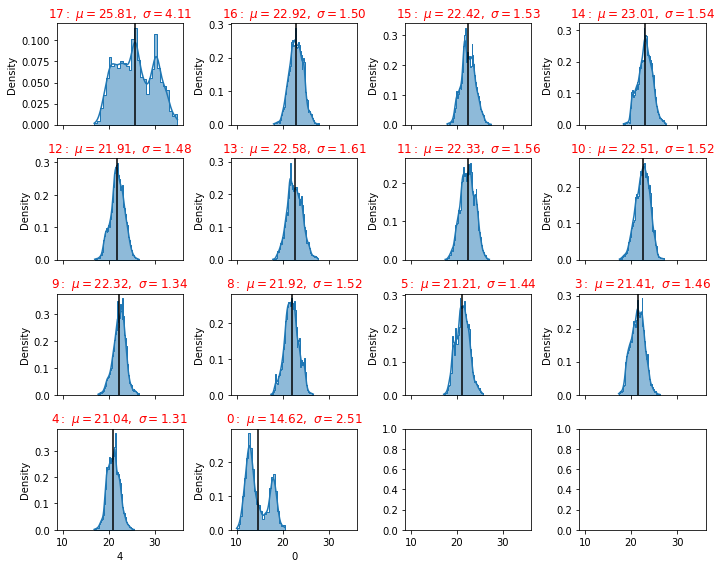

In [144]:
plot_distributions(dfr)

## Model Building

# Logistic Regression

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.


Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature.

It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

Properties of Logistic Regression:

The dependent variable in logistic regression follows Bernoulli Distribution.

When outcome has more than to categories, Multi class regression is used for classification. 
We are going to use One Vs Rest (OVR) algorithm.

This is also called as one vs all algorithm. As name suggest in this algorithm we choose one class and put all other classes into second virtual class and run the binary logistic regression on it. We repeat this procedure for all the classes in the dataset. So we actually end up with binary classifiers designed to recognize each class in dataset

For prediction on given data, our algorithm returns probabilities for each class in the dataset and whichever class has the highest probability is our prediction

The target variable has three or more nominal categories,
Ordinal Logistic Regression: the target variable has three or more ordinal categories such as status of the machine 0 1 2 3 4.

In [145]:
def ovr(df):
    #One Vs Rest (OVR) algorithm.
    ### Test-Train Split
    # Putting feature variable to X
    X = df.drop(['state'], 1)
    #X.head()
    # Putting response variable to y
    y = df['state']
    #Create Test And Train Dataset
    #We will split the dataset, so that we can use one set of data for training the model and one set of data for testing the model
    #We will keep 30% of data for testing and 70% of data for training the model
    # Split the dataset into 70% train and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
  #  print('X_train dimension= ', X_train.shape)
  #  print('X_test dimension= ', X_test.shape)
  #  print('y_train dimension= ', y_train.shape)
  #  print('y_train dimension= ', y_test.shape)
    ## Logistic Regression classifier.
    #In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 
    #This class implements regularized logistic regression using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers.
    #Note that regularization is applied by default. 
    #It can handle both dense and sparse input.
    ## Multi class Logistic Regression Using OVR
    #Since we are going to use One Vs Rest algorithm, set > multi_class='ovr'
    #
    #Note: since we are using One Vs Rest algorithm we must use 'liblinear' solver with it.
    from sklearn import linear_model
    lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
    lm.fit(X_train, y_train)
    ## Testing The Model
    #For testing we are going to use the test data only
    #print('Predicted value is =', lm.predict(X_test))
    #print('Actual value from test data is %s and corresponding image is as below' % (y_test))
    ## Model Score
    #Check the model score using test data
    lm.score(X_test, y_test)
    from sklearn import metrics
    #Creating matplotlib axes object to assign figuresize and figure title
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrx')
    disp =metrics.plot_confusion_matrix(lm, X_test, y_test,  ax = ax)
    disp.confusion_matrix
    print("Classification Report")
    print(metrics.classification_report(y_test, lm.predict(X_test)))
   # Classification report is used to measure the quality of prediction from classification algorithm
    print("Precision: Indicates how many classes are correctly classified")
    print("Recall: Indicates what proportions of actual positives was identified correctly")
    print("F-Score: It is the harmonic mean between precision & recall")
    print("Support: It is the number of occurrence of the given class in our dataset")

    
    

Classification Report
              precision    recall  f1-score   support

         1.0       0.50      0.48      0.49       802
         2.0       0.91      0.97      0.94       809
         3.0       0.61      0.57      0.59       832
         4.0       0.73      0.75      0.74       791

    accuracy                           0.69      3234
   macro avg       0.68      0.69      0.69      3234
weighted avg       0.68      0.69      0.69      3234

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset


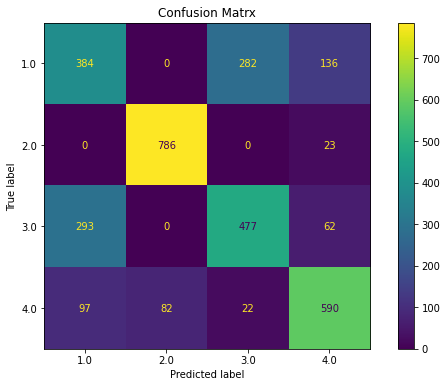

In [146]:
ovr(dfr)

Classification Report
              precision    recall  f1-score   support

         1.0       0.59      0.62      0.60       802
         2.0       1.00      1.00      1.00       809
         3.0       0.61      0.58      0.60       832
         4.0       1.00      1.00      1.00       791

    accuracy                           0.80      3234
   macro avg       0.80      0.80      0.80      3234
weighted avg       0.80      0.80      0.80      3234

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset


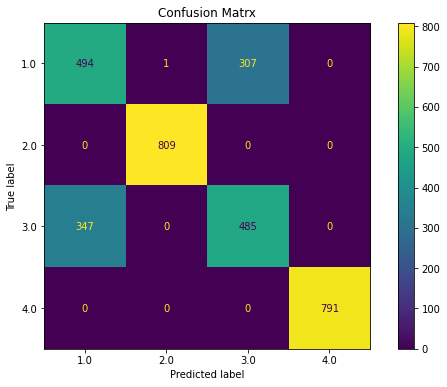

In [147]:
ovr(dfs)

Classification Report
              precision    recall  f1-score   support

         1.0       0.60      0.61      0.60       802
         2.0       1.00      1.00      1.00       809
         3.0       0.62      0.60      0.61       832
         4.0       1.00      1.00      1.00       791

    accuracy                           0.80      3234
   macro avg       0.80      0.80      0.80      3234
weighted avg       0.80      0.80      0.80      3234

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset


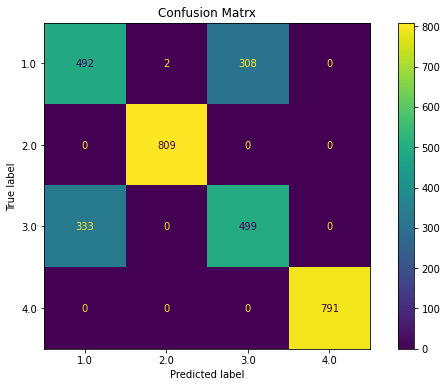

In [148]:
 ovr(x_pca)

In [149]:
def reduce_dataframe(dfc):
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(random_state=1, max_depth=10)
    # Create a selector object that will use the random forest classifier to identify
    feature = SelectFromModel(model)
    dfd=dfc.drop(['state'], axis=1)
    dfe=pd.get_dummies(dfd)
    # Train the selector
    Fit = feature.fit_transform(dfe, dfc)
    dfinal = pd.DataFrame(Fit)
    return dfinal

Classification Report
              precision    recall  f1-score   support

         1.0       0.60      0.61      0.60       802
         2.0       1.00      1.00      1.00       809
         3.0       0.62      0.60      0.61       832
         4.0       1.00      1.00      1.00       791

    accuracy                           0.80      3234
   macro avg       0.80      0.80      0.80      3234
weighted avg       0.80      0.80      0.80      3234

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset


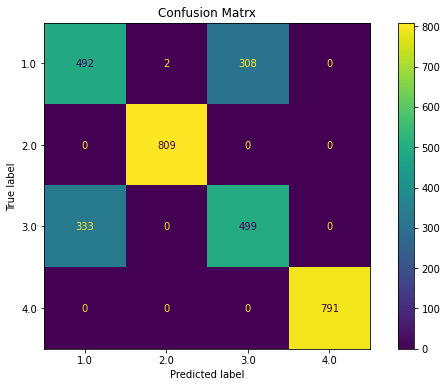

In [150]:
ovr(x_pca)

Classification Report
              precision    recall  f1-score   support

         1.0       0.59      0.62      0.60       802
         2.0       1.00      1.00      1.00       809
         3.0       0.61      0.58      0.60       832
         4.0       1.00      1.00      1.00       791

    accuracy                           0.80      3234
   macro avg       0.80      0.80      0.80      3234
weighted avg       0.80      0.80      0.80      3234

Precision: Indicates how many classes are correctly classified
Recall: Indicates what proportions of actual positives was identified correctly
F-Score: It is the harmonic mean between precision & recall
Support: It is the number of occurrence of the given class in our dataset


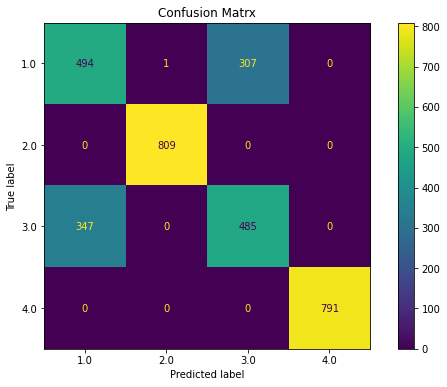

In [151]:
 ovr(dfs)

In [152]:
#load all necessary libraries
import pandas as pd 
import numpy as np 
import scipy as scp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

In [153]:
def multinomial(df):
    X = df.drop(['state'], 1)
    y = df['state']
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
    #Using the training data, we can fit a Multinomial Logistic Regression model, 
     #and then deploy the model on the test dataset to predict classification of individual states. 
    model1 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X_train, y_train)
    preds = model1.predict(X_test)
    #the tunable parameters (They were not tuned in this example, everything kept as default)
    params = model1.get_params()
    #Use statsmodels to assess variables
    logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
    result=logit_model.fit()
    #Create a confusion matrix
    #y_test as first argument and the preds as second argument 
    confusion_matrix(y_test, preds)
    #transform confusion matrix into array
    #the matrix is stored in a vaiable called confmtrx
    confmtrx = np.array(confusion_matrix(y_test, preds))
    dfconf=pd.DataFrame(confmtrx, index=['0','1','2','3'],
    columns=['predicted_0', 'predicted_1', 'predicted_2', 'predicted_3'])
    #Accuracy statistics
    print('Accuracy Score:', metrics.accuracy_score(y_test, preds))  
    #Create classification report
    class_report=classification_report(y_test, preds)
    print(class_report)
    print(dfconf)

In [154]:
multinomial(x_pca)

Optimization terminated successfully.
         Current function value: nan
         Iterations 25
Accuracy Score: 0.8130797773654916
              precision    recall  f1-score   support

         1.0       0.64      0.61      0.62       544
         2.0       1.00      1.00      1.00       542
         3.0       0.61      0.64      0.63       527
         4.0       1.00      1.00      1.00       543

    accuracy                           0.81      2156
   macro avg       0.81      0.81      0.81      2156
weighted avg       0.81      0.81      0.81      2156

   predicted_0  predicted_1  predicted_2  predicted_3
0          331            0          213            0
1            0          542            0            0
2          190            0          337            0
3            0            0            0          543


C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\discrete\discrete_model.py:2290: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\discrete\discrete_model.py:2291: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\base\optimizer.py:413: RuntimeWarning: invalid value encountered in greater
  while (iterations < maxiter and np.any(np.abs(newparams -


In [155]:
multinomial(dfs)

Optimization terminated successfully.
         Current function value: nan
         Iterations 26
Accuracy Score: 0.8130797773654916
              precision    recall  f1-score   support

         1.0       0.64      0.61      0.62       544
         2.0       1.00      1.00      1.00       542
         3.0       0.61      0.64      0.63       527
         4.0       1.00      1.00      1.00       543

    accuracy                           0.81      2156
   macro avg       0.81      0.81      0.81      2156
weighted avg       0.81      0.81      0.81      2156

   predicted_0  predicted_1  predicted_2  predicted_3
0          331            0          213            0
1            0          542            0            0
2          190            0          337            0
3            0            0            0          543


C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\discrete\discrete_model.py:2290: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\discrete\discrete_model.py:2291: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\statsmodels\base\optimizer.py:413: RuntimeWarning: invalid value encountered in greater
  while (iterations < maxiter and np.any(np.abs(newparams -


In [2]:
dfs = pd.read_csv('df_smote.csv')


# Neural Networks

### Creation of the Neural Model

In [3]:
# load dataset
#dataframe = pd.read_csv("dfa_smote.csv")
dataframe=dfs
dataset = dataframe.values
Y = dataset[:,0]  # We select what we want to predict
X = dataset[:,1:].astype(float) # We select the all the features

In [4]:
dataframe.head(3)

,state,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,11.974782,22.257600,22.327462,21.382628,17.659085,23.045132,21.635644,23.967859,22.563081,23.522009,21.542546,26.721223,22.964496,22.570184,22.727158,22.323843,24.638196,25.008335
1,1.0,13.866863,23.816471,19.786581,20.514080,21.160269,18.246760,23.264211,23.079047,22.417103,22.143026,25.109856,23.742411,21.178151,25.913780,22.427613,22.503898,22.920021,24.853088
2,1.0,12.058090,22.939798,21.974368,23.671814,20.072057,19.405997,21.752649,22.355431,24.353079,21.742585,22.125292,23.454627,20.812709,23.219735,20.889096,23.107924,22.485906,21.411143


## Helper functions

In the next section I will requiere some functions to plot the results

In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

##  Neural Network Model

 In this part I will the preliminary neural network

In [8]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

The stantard procedure take the 80% of training and 20% of testing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, dummy_y, train_size=0.8, random_state=seed)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

In [12]:
inputs = dataset.shape[1]-1

In [13]:
model = Sequential()
model.add(Dense(16,activation='relu',input_shape = (inputs,)))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer = 'rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
history = model.fit(x_train, 
                    y_train,
                    epochs = 80,
                    batch_size = 20,
                    verbose=0,
                    validation_data=(x_val,y_val))

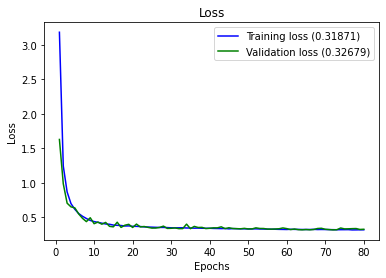

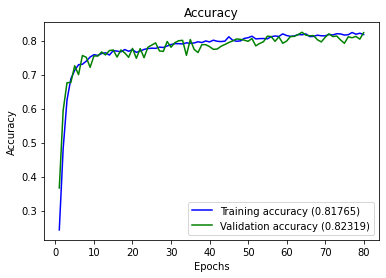

In [15]:
plot_history(history)

C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy : 0.8231884057971014

Classification Report
              precision    recall  f1-score   support

           0    0.71521   0.50457   0.59170       438
           1    1.00000   1.00000   1.00000       446
           2    0.61041   0.79439   0.69036       428
           3    1.00000   1.00000   1.00000       413

    accuracy                        0.82319      1725
   macro avg    0.83141   0.82474   0.82051      1725
weighted avg    0.83103   0.82319   0.81950      1725

[[221   0 217   0]
 [  0 446   0   0]
 [ 88   0 340   0]
 [  0   0   0 413]]


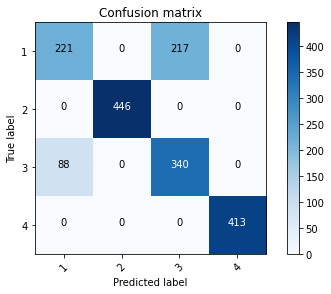

In [16]:
full_multiclass_report(model,
                       x_val,
                       y_val,
                       [1,2,3,4]
                      )

## Tunning Parameters

Due to the unknown nature of the sensors, to determine which are the hyperparameters that are needed,
I will assume one possible structure of neural network which I will prove some activations functions  that  maybe can help. There are 46 fetures or sensors considered.

In [27]:
def create_model(dense_layers=[16],
                 activation='relu',
                 optimizer='rmsprop'):
    model = Sequential()
    for index, lsize in enumerate(dense_layers):
        # Input Layer - includes the input_shape
        if index == 0:
            model.add(Dense(lsize,
                            activation=activation,
                            input_shape=(inputs,)))
        else:
            model.add(Dense(lsize,
                            activation=activation))           
    model.add(Dense(4,activation='softmax'))
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=60, batch_size=10, verbose=0)

In [29]:
# define the grid search parameters
optimizer = ['rmsprop','adam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid']
param_grid = dict(activation=activation,optimizer = optimizer)

In [30]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)

The following operation will take at least 30 minutes or more depending the power computing.

In [31]:
grid_result = grid.fit(X, dummy_y)

In [32]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.501763 using {'activation': 'relu', 'optimizer': 'adam'}
0.473655 (0.026345) with: {'activation': 'softmax', 'optimizer': 'rmsprop'}
0.113451 (0.080056) with: {'activation': 'softmax', 'optimizer': 'adam'}
0.438961 (0.061039) with: {'activation': 'softplus', 'optimizer': 'rmsprop'}
0.486920 (0.013080) with: {'activation': 'softplus', 'optimizer': 'adam'}
0.432560 (0.067440) with: {'activation': 'softsign', 'optimizer': 'rmsprop'}
0.488312 (0.011688) with: {'activation': 'softsign', 'optimizer': 'adam'}
0.340445 (0.159555) with: {'activation': 'relu', 'optimizer': 'rmsprop'}
0.501763 (0.001763) with: {'activation': 'relu', 'optimizer': 'adam'}
0.394712 (0.095269) with: {'activation': 'tanh', 'optimizer': 'rmsprop'}
0.088961 (0.055566) with: {'activation': 'tanh', 'optimizer': 'adam'}
0.433210 (0.066790) with: {'activation': 'sigmoid', 'optimizer': 'rmsprop'}
0.436827 (0.063173) with: {'activation': 'sigmoid', 'optimizer': 'adam'}
0.250000 (0.250000) with: {'activation': 'hard_si

## Final Neural Network Model

By using different tests of parameters we got the following network

In [52]:
model = Sequential()
model.add(Dense(16,activation='relu',input_shape = (inputs,)))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer = 'adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [53]:
history = model.fit(x_train, 
                    y_train,
                    epochs = 80,
                    batch_size = 20,
                    verbose=0,
                    validation_data=(x_val,y_val))

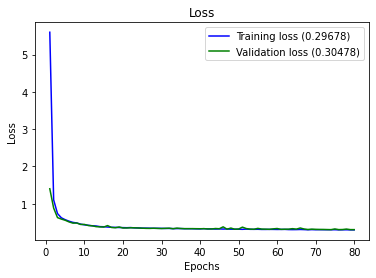

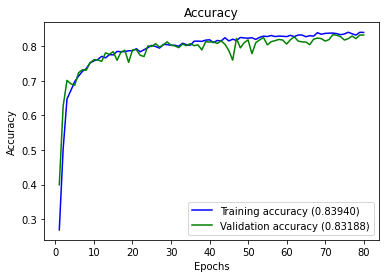

In [43]:
plot_history(history)

C:\Users\rusla\.conda\envs\tf-keras-gpu-test\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy : 0.8318840579710145

Classification Report
              precision    recall  f1-score   support

           0    0.72024   0.55251   0.62532       438
           1    1.00000   1.00000   1.00000       446
           2    0.63158   0.78505   0.70000       428
           3    1.00000   0.99516   0.99757       413

    accuracy                        0.83188      1725
   macro avg    0.83795   0.83318   0.83072      1725
weighted avg    0.83755   0.83188   0.82985      1725

[[242   0 196   0]
 [  0 446   0   0]
 [ 92   0 336   0]
 [  2   0   0 411]]


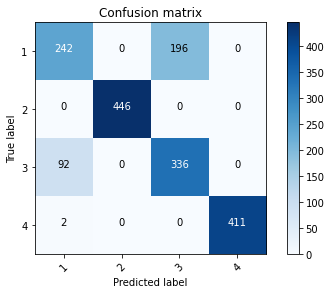

In [44]:
full_multiclass_report(model,
                       x_val,
                       y_val,
                       [1,2,3,4]
                      )

## Discussion of the Objective 1

 1. It was read the data and labels from disk and converted to the appropiate dataframe for the develiping of the machine learning model.
 2. It was seen that  there is unbalanced values of the state 1 and the rest of them, so  it is suggested separate the state 1 from the rest of the anomalies during the labelig.
 3. We have developed a model that allows identify any of the states 1 to 4
 4. Another possible solution is develop two models of classification,one to identify if they have anomalies and the second model of classification with type of anomaly it has.

## Discussion of the Objective 2

**Situation**:
In a real-world-like scenario, a new sample generated from the same process 
arrives every 30 minutes, and it is stored in a database. The ML anomaly detection 
system automatically classifies the data setting a label between 1 and 4 as the 
standard operation described earlier. Every few days, a human expert analyses
some of the newly arrived samples with the associated label (from 1 to 4) and the 
ML anomaly detection systems auto-updates.
The ML anomaly detection system must generate a report about its performance 
over time.

**Solution**:
A possible solution of this Scenario shoud be develop an **ETL** that validates the incomming data from the machines, should be filtered before the data should be written into the database.
The manner to do this, is define an schema of the data and validate them
before it goes to the database, in manner to avoid write records with null values or empty values.
for example, adding an extra task during the ingestion of the data something like this:

In [45]:
from jsonschema import validate
from jsonschema.exceptions import ValidationError
import json
def check_schema(data_dict, schema):
    try:
        validate(data_dict, schema=schema)
        # print("OK")
    except ValidationError as e:
        print(e.message)

and if the schema is correct later can be stored to the database.It can be scheduled action that each  30 minutes check the new data and moves to the database In addition during the ingestion of the data it is possible to save also the logs of the erros and store them in another database to analize the source of the errors.

Congratulations we have practiced different techniques of mutilclass classification